# Human Activity Recognition

### 데이터 확인

In [1]:
import pandas as pd

fn_df = pd.read_csv('../00. data/UCI_HAR_Dataset/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
fn_df

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [2]:
fn_dup_df = fn_df.groupby('column_name').count()
fn_dup_df

,column_index
column_name,
"angle(X,gravityMean)",1
"angle(Y,gravityMean)",1
"angle(Z,gravityMean)",1
"angle(tBodyAccJerkMean),gravityMean)",1
"angle(tBodyAccMean,gravity)",1
...,...
tGravityAccMag-max(),1
tGravityAccMag-mean(),1
tGravityAccMag-min(),1


### 중복되는 항목 정리 & 학습/테스트 데이터 도출

In [3]:
def get_new_fn_df(fn_df):
    f_dup_df = pd.DataFrame(data=fn_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    f_dup_df = f_dup_df.reset_index()
    new_fn_df =pd.merge(fn_df.reset_index(), f_dup_df, how='outer')
    new_fn_df['column_name'] = new_fn_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_fn_df = new_fn_df.drop(['index'], axis=1)
    return new_fn_df

In [4]:
def get_HAR_dataset():
    fn_df = pd.read_csv('../00. data/UCI_HAR_Dataset/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    new_fn_df = get_new_fn_df(fn_df)
    feature_name = new_fn_df.iloc[:, 1].values.tolist()
    X_train = pd.read_csv('../00. data/UCI_HAR_Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('../00. data/UCI_HAR_Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    y_train = pd.read_csv('../00. data/UCI_HAR_Dataset/train/y_train.txt', sep='\s+', names=['action'])
    y_test = pd.read_csv('../00. data/UCI_HAR_Dataset/test/y_test.txt', sep='\s+', names=['action'])

    return X_train, X_test, y_train, y_test, feature_name

In [5]:
X_train, X_test, y_train, y_test, feature_name = get_HAR_dataset()

### 최적 파라미터, 최고 정확도 찾기(하이퍼 파라미터 튜닝, 교차 검증)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier()
parameters = {'max_depth': [4, 6, 8, 12, 14, 16, 20], 'min_samples_split': [8, 10, 12, 14, 16, 20, 24]}
grid_dt = GridSearchCV(dt, param_grid=parameters, cv=5, scoring='accuracy', refit=True)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 6, 8, 12, 14, 16, 20],
                         'min_samples_split': [8, 10, 12, 14, 16, 20, 24]},
             scoring='accuracy')

In [7]:
print('GridSearchCV 최적 파라미터:', grid_dt.best_params_)
print('GridSearchCV 최고 정확도:, {0:.4f}'.format(grid_dt.best_score_))

GridSearchCV 최적 파라미터: {'max_depth': 8, 'min_samples_split': 8}
GridSearchCV 최고 정확도:, 0.8539


In [8]:
from sklearn.metrics import accuracy_score
estimator = grid_dt.best_estimator_
pred = estimator.predict(X_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

테스트 데이터 세트 정확도: 0.8704


### 중요한 feature 항목 찾기

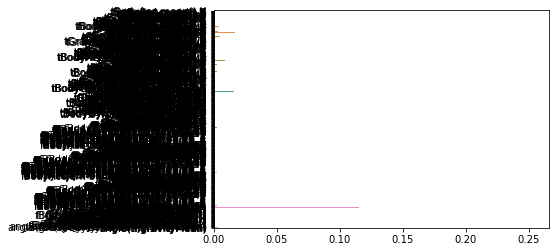

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sns.barplot(x=estimator.feature_importances_, y=feature_name);

In [10]:
feature_im = pd.DataFrame(estimator.feature_importances_, index=feature_name)
feature_im.head()

,0
tBodyAcc-mean()-X,0.0
tBodyAcc-mean()-Y,0.0
tBodyAcc-mean()-Z,0.0
tBodyAcc-std()-X,0.0
tBodyAcc-std()-Y,0.0


In [11]:
important_feat = feature_im.sort_values(by=0, ascending=False).head(20)
important_feat

,0
tGravityAcc-min()-X,0.253040
fBodyAcc-mean()-X,0.212320
"angle(Y,gravityMean)",0.138828
fBodyAccMag-energy(),0.115335
"tGravityAcc-arCoeff()-Z,2",0.101422
fBodyGyro-maxInds-X,0.023941
"tBodyGyro-correlation()-Y,Z",0.016493
tGravityAcc-energy()-Y,0.016413
tBodyAccMag-arCoeff()1,0.015722
fBodyAcc-max()-Y,0.008814


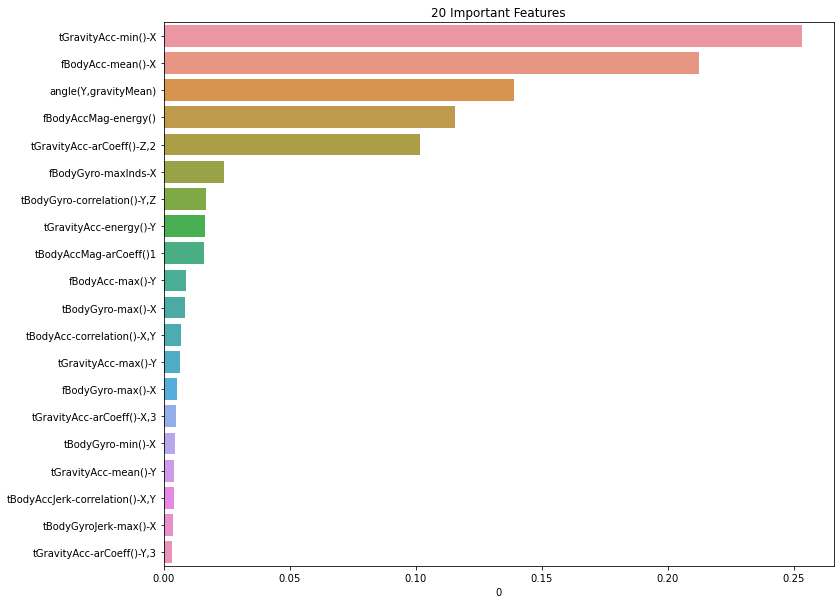

In [12]:
plt.figure(figsize=(12, 10))
plt.title('20 Important Features')
sns.barplot(x=important_feat[0], y=important_feat.index)
plt.show()